# **Assignment 5. Residual Network**

* 看懂Residual Network樣板程式，解析其網路結構。
* 基於樣板設計一個Residual Network, 與作業四VGG模型進行分析與比較(那個模型較好，為什麼?)。
* (Optional)比較多個不同深度Residual Networks (以Residual Block為單位)，檢視”Deeper is Better”是否成立。

In [1]:
# Install old-version Tensorflow if necessary
!pip install tensorflow==2.7.0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.7.0 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.7.0


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


<ipython-input-3-2250735223>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  title = "l=" + class_names[int(labels[idx])]
<ipython-input-3-2250735223>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  title = "l={}".format(class_names[int(labels[idx])])


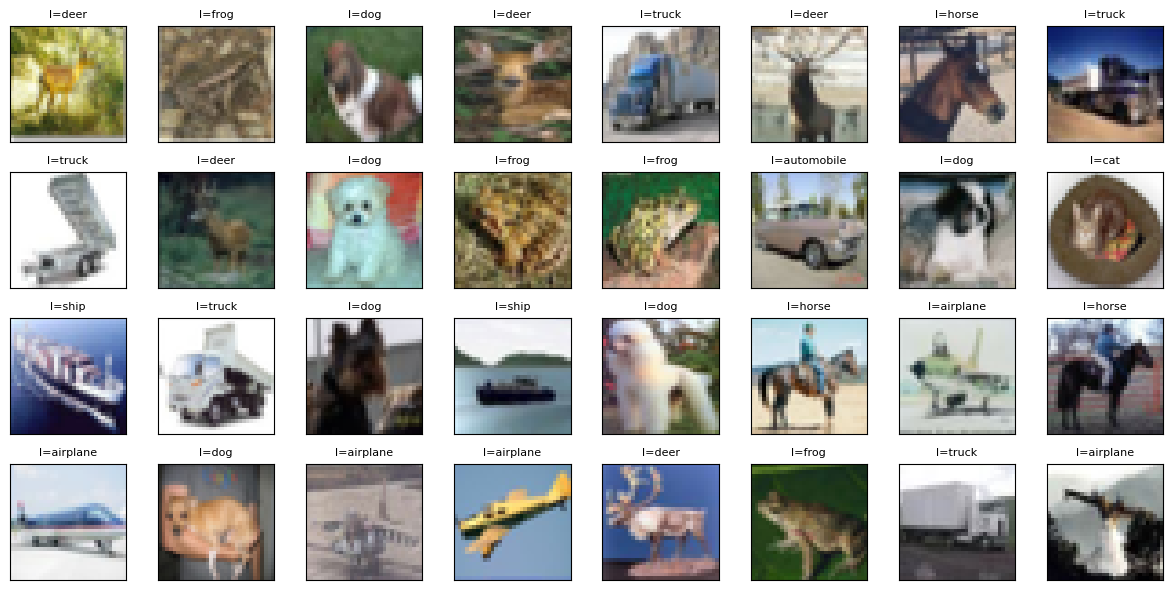

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers, initializers, optimizers, metrics
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input, Add, AveragePooling2D, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Loading the CIFAR-10 dataset
from keras.datasets import cifar10

# Declare variables
(x_train_image, y_train_label), (x_test_image, y_test_label) = cifar10.load_data() # x_train - training data(images), y_train - labels(digits)
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

def plot_multiimages(images, labels, prediction, idx, num=32):
    fig, ax = plt.subplots(4, 8, figsize=(12, 6))
    if num > 32: num = 32
    for i in range(0, num):
        ax=plt.subplot(4,8, 1+i)
        ax.imshow(images[idx])
        title = "l=" + class_names[int(labels[idx])]
        if len(prediction) > 0:
            title = "l={},p={}".format(class_names[int(labels[idx])], class_names[prediction[idx]])
        else:
            title = "l={}".format(class_names[int(labels[idx])])
        ax.set_title(title, fontsize=8)
        ax.set_xticks([]); ax.set_yticks([])
        idx+=1
    plt.tight_layout()
    plt.show()

plot_multiimages(x_test_image, y_test_label, [], 500, 32)

# Convert and pre-processing
x_train = x_train_image.reshape(len(x_train_image), 32, 32, 3).astype('float32')
x_test = x_test_image.reshape(len(x_test_image), 32, 32, 3).astype('float32')
x_train_norm = x_train/255
x_test_norm = x_test/255
y_TrainOneHot = utils.to_categorical(y_train_label)
y_TestOneHot = utils.to_categorical(y_test_label)

### **A1. Residual Block**
* identity_block()
* convolutional_block()

In [4]:
def identity_block(X, filters):
    # Retrieve Filters
    F1, F2, F3 = filters
    # Save the input value
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='same')(X)
    X = BatchNormalization()(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, filters):
    # Retrieve Filters
    F1, F2, F3 = filters
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(2, 2), padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='same')(X)
    X = BatchNormalization()(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(2, 2), padding='same')(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X

### **A2. Residual Network**

In [8]:
def ResidualNetwork(input_shape=(32, 32, 3), classes=10):
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Stage 1
    X = Conv2D(64, (3, 3), padding='same')(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Stage 2
    X = identity_block(X, [16, 16, 64])
    X = identity_block(X, [16, 16, 64])
    X = identity_block(X, [16, 16, 64])
    X = identity_block(X, [16, 16, 64])
    X = identity_block(X, [16, 16, 64])
    X = identity_block(X, [16, 16, 64])
    X = identity_block(X, [16, 16, 64])

    # Stage 3
    X = convolutional_block(X, filters=[32, 32, 128])
    X = identity_block(X, [32, 32, 128])
    X = identity_block(X, [32, 32, 128])
    X = identity_block(X, [32, 32, 128])
    X = identity_block(X, [32, 32, 128])
    X = identity_block(X, [32, 32, 128])

    # Stage 4
    X = convolutional_block(X, filters=[64, 64, 256])
    X = identity_block(X, [64, 64, 256])
    X = identity_block(X, [64, 64, 256])


    # AVGPOOL
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # Output layer
    X = Flatten()(X)
    X = Dropout(0.5)(X)
    X = Dense(classes, activation='softmax')(X)

    # Create model
    ResNet_model = Model(inputs=X_input, outputs=X)
    return ResNet_model

### **A3. Model Training**

In [9]:
ResNet = ResidualNetwork(input_shape = (32, 32, 3), classes = 10)
ResNet.summary()
ResNet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#train_history = ResNet.fit(x_train_norm, y_TrainOneHot, batch_size=32, epochs=20, shuffle=True, validation_split=0.2, verbose=2)

img_gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.15, height_shift_range=0.15,
                             horizontal_flip=True, zoom_range=0.1, validation_split=0.2)

batch_size = 32
train_generator = img_gen.flow(x_train_norm, y_TrainOneHot, batch_size=batch_size, subset='training')
val_generator = img_gen.flow(x_train_norm, y_TrainOneHot, batch_size=batch_size, subset='validation')

steps = train_generator.n // train_generator.batch_size
validation_steps = val_generator.n // val_generator.batch_size

early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
train_history = ResNet.fit(train_generator, steps_per_epoch=steps, validation_data=val_generator,
                           validation_steps=validation_steps, epochs=75, shuffle=True, callbacks=[early_stopping, reduce_lr])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 32, 32,    │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_54[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_52       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 32, 32,    │      1,040 │ activation_52[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_55[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_53       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 32, 32,    │      2,320 │ activation_53[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_56[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_54       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 32, 32,    │      1,088 │ activation_54[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ activation_52[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_55       │ (None, 32, 32,    │          0 │ add_17[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 32, 32,    │      1,040 │ activation_55[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_58[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_56       │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 434,346 (1.66 MB)

 Trainable params: 427,498 (1.63 MB)

 Non-trainable params: 6,848 (26.75 KB)

Epoch 1/75
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 104s 44ms/step - accuracy: 0.2276 - loss: 2.6972 - val_accuracy: 0.3926 - val_loss: 1.7185 - learning_rate: 0.0010
Epoch 2/75
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 52s 41ms/step - accuracy: 0.4063 - loss: 1.6332 - val_accuracy: 0.4087 - val_loss: 1.6675 - learning_rate: 0.0010
Epoch 3/75
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - accuracy: 0.4757 - loss: 1.4519 - val_accuracy: 0.4812 - val_loss: 1.4453 - learning_rate: 0.0010
Epoch 4/75
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 41ms/step - accuracy: 0.5254 - loss: 1.3167 - val_accuracy: 0.5421 - val_loss: 1.2992 - learning_rate: 0.0010
Epoch 5/75
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - accuracy: 0.5742 - loss: 1.1832 - val_accuracy: 0.5978 - val_loss: 1.1295 - learning_rate: 0.0010
Epoch 6/75
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 89ms/step - accuracy: 0.6092 - loss: 1.0960 - val_accuracy: 0.6090 - val_loss: 1.1150 - learning_rate: 0.0010
Epoch 7/75
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 41ms/step - accu

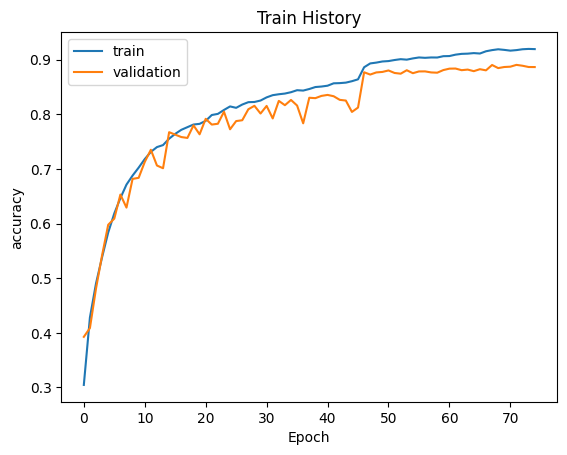

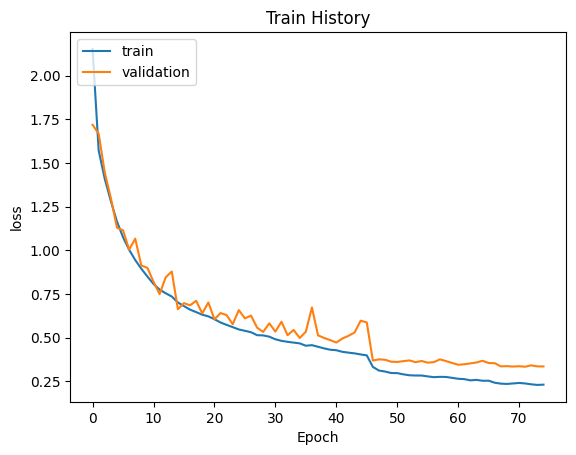

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8930 - loss: 0.3496

	[Info] Accuracy of testing data = 89.2%
	[Info] Making prediction to x_test_norm


In [10]:
# Plots for trainng and testing process: loss and accuracy
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
show_train_history(train_history, 'accuracy', 'val_accuracy')
show_train_history(train_history, 'loss', 'val_loss')

scores = ResNet.evaluate(x_test_norm, y_TestOneHot)
print()
print("\t[Info] Accuracy of testing data = {:2.1f}%".format(scores[1]*100.0))
print("\t[Info] Making prediction to x_test_norm")